In [ ]:
# importing libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
!pip install tensorflow==2.10.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 74.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [ ]:
# %tensorflow_version 2.10


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, optimizers, callbacks
from PIL import Image
import requests
from io import BytesIO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


# 1. Loading the data

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Put Colab in the context of this challenge
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense')

In [ ]:
!pwd


/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense


In [ ]:
!ls

dummy_model_data_aug.h5  good_model.h5	    models		    notebooks  README.md
dummy_model.h5		 model_data_aug.h5  model_transferLearn.h5  raw_data


In [ ]:
!ls raw_data

sign_asl


In [ ]:

def load_asl_data():

    data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_train/asl_alphabet_train'
    classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:3001]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((100, 100))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_asl_data()


100%|██████████| 3000/3000 [01:27<00:00, 34.25it/s] 


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(51300, 100, 100, 3) (16200, 100, 100, 3) (13500, 100, 100, 3)


In [ ]:
X_train[0].shape

(100, 100, 3)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 2 .Visualization

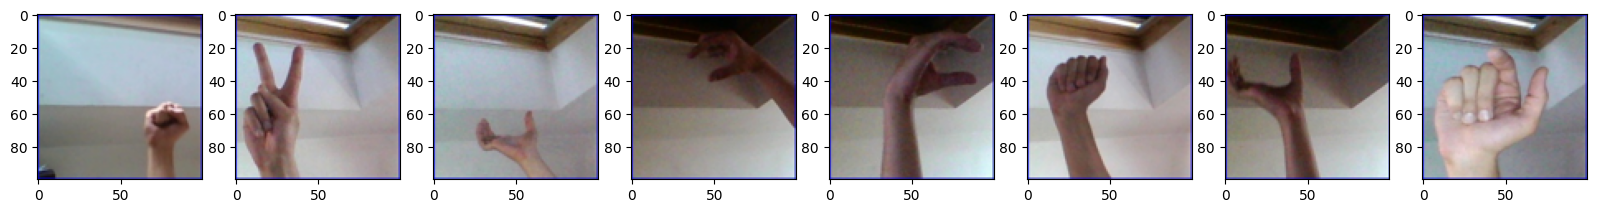

In [ ]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

# 3. CNN Models

## 3.1 Dummy model

In [ ]:
def dummy_model():
  input_shape= X_train[0].shape
  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2))


# prediction layer
  model.add(layers.Dense(27, activation="softmax"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [ ]:
dummy_model= dummy_model()
dummy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       7

In [ ]:
MODEL = "dummy_model_size100"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = dummy_model.fit(X_train, y_train,
        epochs=3,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/3
1604/1604 [==============================] - 1159s 722ms/step - loss: 1.5051 - accuracy: 0.5219 - val_loss: 0.3510 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 2/3
1604/1604 [==============================] - 1156s 720ms/step - loss: 0.4016 - accuracy: 0.8617 - val_loss: 0.0847 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 3/3
1604/1604 [==============================] - 1157s 721ms/step - loss: 0.2179 - accuracy: 0.9255 - val_loss: 0.0585 - val_accuracy: 0.9860 - lr: 0.0010
CPU times: user 1h 28min 13s, sys: 6min 20s, total: 1h 34min 33s
Wall time: 57min 53s


In [ ]:
dummy_model.save('/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/models/dummy_model_100size.h5')

In [ ]:
model_dummy = load_model("models/dummy_model_100size.h5")

In [ ]:
# Evaluation:
res = model_dummy.evaluate(X_test, y_test)
res

422/422 [==============================] - 80s 190ms/step - loss: 0.0538 - accuracy: 0.9863


[0.053789395838975906, 0.9862962961196899]

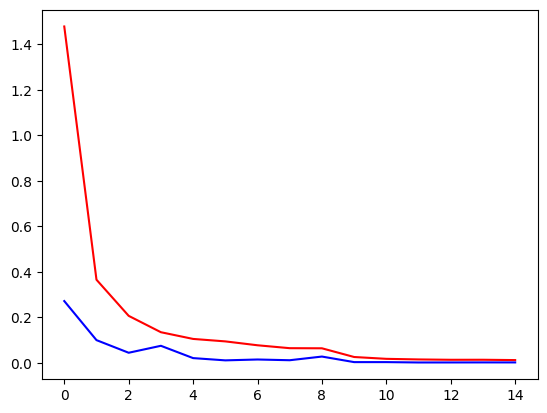

In [ ]:
plt.plot(history.history["loss"], 'r')
plt.plot(history.history["val_loss"], 'b')


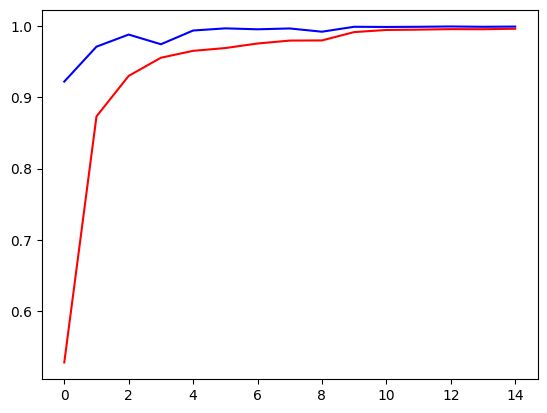

In [ ]:
plt.plot(history.history["accuracy"], 'r')
plt.plot(history.history["val_accuracy"], 'b')

### 3.1.1 prediction

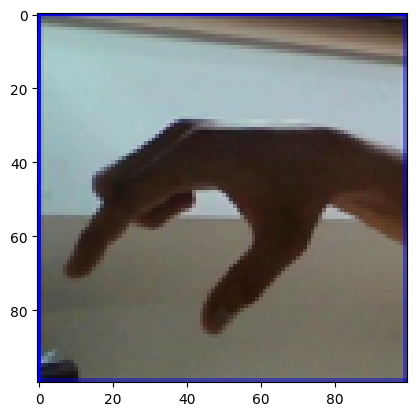

In [ ]:

test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[7])
image = Image.open(path)
image = image.resize((100, 100))
plt.imshow(image)

In [ ]:
path = os.path.join(test_data_path, files[2])
path

'/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test/I_test.jpg'

In [ ]:
img = np.array(image)
img = img.reshape((-1, 100, 100, 3))
res = model_dummy.predict(img)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 436ms/step
['Q']


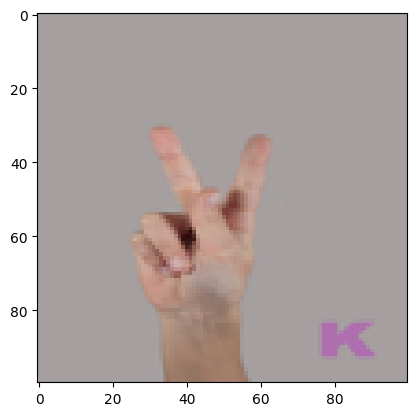

In [ ]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((100, 100))
plt.imshow(img)


In [ ]:
img2 = np.array(img)
img2 = img2.reshape((-1, 100, 100, 3))
res = model_dummy.predict(img2)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 41ms/step
['nothing']


In [ ]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)


['nothing']


## 3.2 Good model

In [ ]:
X_train[0].shape

(100, 100, 3)

In [ ]:
def good_model():
  input_shape= X_train[0].shape
  # Instantiating as an example an L1-regularizer with alpha = 0.01
  reg_l2 = regularizers.L2(0.01)

  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 64, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 512, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 1024, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )



  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(512, activation="relu", kernel_regularizer = reg_l2))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

  model.add(layers.Dense(64, activation="relu", kernel_regularizer = reg_l2))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())



# prediction layer
  model.add(layers.Dense(27, activation="softmax"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [ ]:
model_good = good_model()
model_good.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 64)      4864      
                                                                 
 batch_normalization_34 (Ba  (None, 100, 100, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 50, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 512)       295424    
                                                                 
 batch_normalization_35 (Ba  (None, 50, 50, 512)      

In [ ]:

MODEL = "good_model_trainsize100"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = model_good.fit(X_train, y_train,
        epochs=20,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/20
 150/1604 [=>............................] - ETA: 8:14:49 - loss: 13.2854 - accuracy: 0.1590

KeyboardInterrupt: 

### 3.2.1 prediction

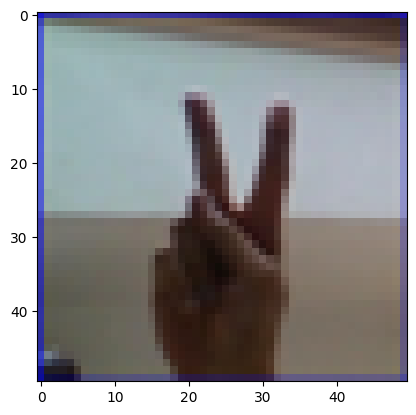

In [ ]:
test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((100, 100))
plt.imshow(image)

In [ ]:
img = np.array(image)
img = img.reshape((-1, 100, 100, 3))
res = model_good.predict(img)
res

1/1 [==============================] - 1s 513ms/step


array([[9.7288394e-01, 6.2931657e-01, 2.7842805e-01, 2.5322703e-01,
        7.3229350e-02, 7.8490877e-01, 8.7142390e-01, 9.0618086e-01,
        9.5436317e-01, 1.0000000e+00, 8.8863778e-01, 5.3122115e-01,
        2.6026350e-01, 9.0381004e-02, 1.6711089e-04, 4.1118208e-01,
        9.8696125e-01, 1.4318649e-03, 3.2329306e-02, 2.8647441e-01,
        9.9739408e-01, 9.6363670e-01, 3.1419963e-02, 8.4232837e-02,
        1.1376056e-01, 9.5310397e-02, 7.8518018e-03]], dtype=float32)

In [ ]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['K']


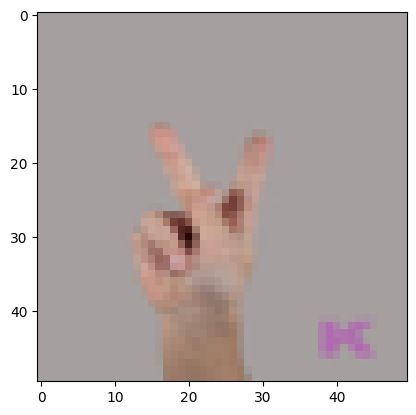

In [ ]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((100, 100))
plt.imshow(img)


In [ ]:
img2 = np.array(img)
img2 = img2.reshape((-1, 100, 100, 3))
res = model_good.predict(img2)
res

1/1 [==============================] - 0s 19ms/step


array([[0.45837435, 0.0191789 , 0.8735937 , 0.74377763, 0.08869368,
        0.49061754, 0.12937957, 0.01885567, 0.11070115, 0.8708485 ,
        0.97524613, 0.42136705, 0.8970884 , 0.9816745 , 0.11446963,
        0.41618937, 0.13643913, 0.7872582 , 0.9950429 , 0.3039112 ,
        0.99668556, 0.8353337 , 0.9387479 , 0.53848034, 0.7555547 ,
        0.18098977, 0.9020709 ]], dtype=float32)

In [ ]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['V']


## 3.3 Model with data augmentation

In [ ]:
# testing dummy model with data augmentation

In [ ]:


MODEL = "dummy_model_data_aug"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
datagen = ImageDataGenerator(
featurewise_center = False,
featurewise_std_normalization = False,
rotation_range = 20,
width_shift_range = 0.2,
height_shift_range = 0.2,
horizontal_flip = False,
vertical_flip = False,
brightness_range = (0.5, 1.),
zoom_range = (0.3, 1.5),
shear_range=0.2,
zca_whitening=False,
zca_epsilon=0.001,
fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
%%time
model_augm_dummy= dummy_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
val_flow = datagen.flow(X_val, y_val, batch_size=16)

history_data_augdummy = model_augm_dummy.fit(train_flow,
validation_data = val_flow,
epochs = 20,
callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

Epoch 1/20
3207/3207 [==============================] - ETA: 0s - loss: 2.8137 - accuracy: 0.1735

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3207/3207 [==============================] - 457s 142ms/step - loss: 2.8137 - accuracy: 0.1735 - val_loss: 2.1304 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 2/20
3207/3207 [==============================] - 455s 142ms/step - loss: 1.9564 - accuracy: 0.3796 - val_loss: 1.5802 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 3/20
3207/3207 [==============================] - 466s 145ms/step - loss: 1.5853 - accuracy: 0.4880 - val_loss: 1.2644 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 4/20
3207/3207 [==============================] - 486s 152ms/step - loss: 1.3836 - accuracy: 0.5465 - val_loss: 1.1636 - val_accuracy: 0.6169 - lr: 0.0010
Epoch 5/20
3207/3207 [==============================] - 471s 147ms/step - loss: 1.2469 - accuracy: 0.5884 - val_loss: 0.9963 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 6/20
3207/3207 [==============================] - 449s 140ms/step - loss: 1.1600 - accuracy: 0.6177 - val_loss: 0.8917 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 7/20
3207/3207 [=======================

In [ ]:
# testing good model with data augmentation

In [ ]:


MODEL = "model_good_data_aug"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
model_good_augm= good_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
val_flow = datagen.flow(X_val, y_val, batch_size=16)

history_data_auggood = model_good_augm.fit(train_flow,
validation_data = val_flow,
epochs = 20,
callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

Epoch 1/20
3207/3207 [==============================] - ETA: 0s - loss: 2.9125 - accuracy: 0.1453

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3207/3207 [==============================] - 2416s 752ms/step - loss: 2.9125 - accuracy: 0.1453 - val_loss: 2.9622 - val_accuracy: 0.1543 - lr: 0.0010
Epoch 2/20
3207/3207 [==============================] - 2505s 781ms/step - loss: 2.0891 - accuracy: 0.3518 - val_loss: 0.9029 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 3/20
3207/3207 [==============================] - 2468s 769ms/step - loss: 1.5216 - accuracy: 0.5235 - val_loss: 0.4526 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 4/20
3207/3207 [==============================] - 2431s 758ms/step - loss: 1.2882 - accuracy: 0.5992 - val_loss: 1.8801 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 5/20
3207/3207 [==============================] - 2446s 763ms/step - loss: 1.2084 - accuracy: 0.6240 - val_loss: 0.2493 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 6/20
3207/3207 [==============================] - 2485s 775ms/step - loss: 1.0714 - accuracy: 0.6679 - val_loss: 0.2071 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 7/20
3207/3207 [=================

### 3.3.1 prediction

In [ ]:
model_dummyaugm = load_model("dummy_model_data_aug.h5")

In [ ]:
res = model_dummyaugm.evaluate(X_test, y_test)
res

422/422 [==============================] - 28s 64ms/step - loss: 0.0867 - accuracy: 0.9693


[0.08671897649765015, 0.9692592620849609]

In [ ]:
test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((100, 100))
img = np.array(image)
img = img.reshape((-1, 50, 50, 3))
res = model_dummyaugm.predict(img)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 24ms/step
['K']


In [ ]:
url1= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
url2='https://as1.ftcdn.net/v2/jpg/02/19/73/28/1000_F_219732832_JCFEUdJCjWu4EIKQ5qVIkYYACRqMjmts.jpg'
url3='https://c8.alamy.com/comp/2BFHG9H/finger-spelling-the-alphabet-in-american-sign-language-asl-letter-k-2BFHG9H.jpg'
url4='https://thumbs.dreamstime.com/b/finger-spelling-letter-k-american-sign-language-white-background-asl-concept-finger-spelling-letter-k-american-sign-162124713.jpg'
url5='https://static3.bigstockphoto.com/1/5/1/large1500/151482908.jpg'
url6='https://media.istockphoto.com/id/1252389496/vector/hand-gesture-showing-letter-k-on-american-sign-language.jpg?s=612x612&w=is&k=20&c=r_-WoGyc3JfBfYDFibn_oeYBa9vhNZ2JsG_TzEJLhE0='
url7='https://img.freepik.com/premium-photo/letter-k-american-sign-language-asl-deaf-people_568886-879.jpg'
url8='https://previews.123rf.com/images/tony4urban/tony4urban1412/tony4urban141200226/34780391-sign-language-american-alphabet-with-hands-painted-white-over-black-background-letter-k.jpg'
url9='https://as1.ftcdn.net/v2/jpg/02/59/04/48/1000_F_259044897_ZthKmQcde2XOz8KSSfLFrdeogRaJraNG.jpg'
url10='https://previews.123rf.com/images/tootles/tootles0603/tootles060300049/350353-alphabet-letter-k-in-sign-language-for-deaf.jpg'
response = requests.get(url10)
img = Image.open(BytesIO(response.content))
img = img.resize((100, 100))
img2 = np.array(img)
img2 = img2.reshape((-1, 100, 100, 3))
res = dummy_model.predict(img2)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 73ms/step
['L']


In [ ]:
model_augm = load_model("model_data_aug.h5")

In [ ]:
res = model_augm.evaluate(X_test, y_test)
res

422/422 [==============================] - 121s 285ms/step - loss: 0.0831 - accuracy: 0.9699


[0.08314130455255508, 0.9698518514633179]

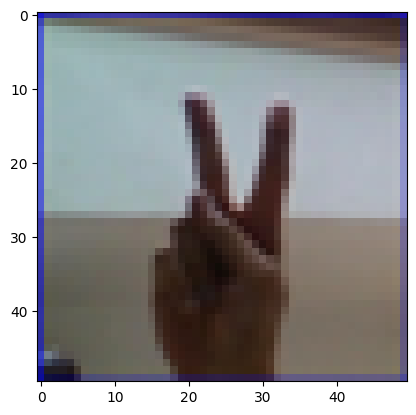

In [ ]:
test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((100, 100))
plt.imshow(image)

In [ ]:
img = np.array(image)
img = img.reshape((-1, 100, 100, 3))
res = model_augm.predict(img)
res

1/1 [==============================] - 0s 34ms/step


array([[1.09408915e-01, 8.38807762e-01, 1.36413097e-01, 9.53763902e-01,
        9.54458024e-03, 5.34354985e-01, 9.09258783e-01, 6.31818324e-02,
        2.28198897e-02, 9.99986112e-01, 9.73684490e-01, 4.91142750e-01,
        8.37229714e-02, 6.01300061e-01, 1.56441987e-01, 5.71889393e-02,
        7.02667594e-01, 4.79775335e-05, 5.82322711e-03, 3.24062914e-01,
        9.98146117e-01, 8.90163660e-01, 2.66180653e-02, 2.07194639e-03,
        1.02516450e-03, 6.45123199e-02, 1.26467377e-01]], dtype=float32)

In [ ]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['K']


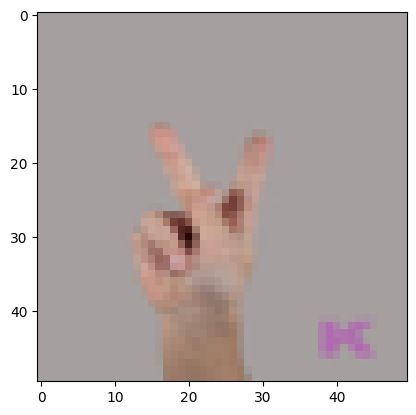

In [ ]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((100, 100))
plt.imshow(img)


In [ ]:
img2 = np.array(img)
img2 = img2.reshape((-1, 100, 100, 3))
res = model_augm.predict(img2)
res

1/1 [==============================] - 0s 56ms/step


array([[0.5311052 , 0.15780558, 0.8560164 , 0.70139086, 0.04772735,
        0.8807366 , 0.46148294, 0.01786064, 0.02014466, 0.9836691 ,
        0.9975512 , 0.30367276, 0.12455937, 0.6792351 , 0.449766  ,
        0.47042027, 0.24996477, 0.02433522, 0.9256191 , 0.25150827,
        0.98229784, 0.9025967 , 0.54560745, 0.67136425, 0.22885066,
        0.08205762, 0.96495163]], dtype=float32)

In [ ]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['L']


## 3.4 Model with transfer learning

In [ ]:
def load_model():
    '''Take a pre-trained model, set its parameters as non-trainable'''
    # loading of vgg16 model
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [ ]:
model= load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def add_last_layers():

    # add additional trainable layers on top

    base_model = load_model()
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(512, activation='relu')# first dense layer
    dropout_1 = layers.Dropout(0.2)  # Add dropout layer with dropout rate of 0.3
    dense_layer_2 = layers.Dense(128, activation='relu')  # Additional dense layer
    dropout_2 = layers.Dropout(0.2)  # Add dropout layer with dropout rate of 0.2
    dense_layer_3 = layers.Dense(64, activation='relu')  # Additional dense layer
    dropout_3 = layers.Dropout(0.2)  # Add dropout layer with dropout rate of 0.2

    prediction_layer = layers.Dense(27, activation='softmax') # prediction layer


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dropout_1,
        dense_layer_2,
        dropout_2,
        dense_layer_3,
        dropout_3,
        prediction_layer
    ])
    # compiling
    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])

    return model

In [ ]:
model_transferLearn= add_last_layers()
model_transferLearn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [ ]:


MODEL = "model_transferLearn"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = model_transferLearn.fit(X_train, y_train,
        epochs=20,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/20
1604/1604 [==============================] - ETA: 0s - loss: 1.3500 - accuracy: 0.6032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1604/1604 [==============================] - 1752s 1s/step - loss: 1.3500 - accuracy: 0.6032 - val_loss: 0.3853 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 2/20
1604/1604 [==============================] - 1768s 1s/step - loss: 0.4737 - accuracy: 0.8495 - val_loss: 0.2311 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 3/20
1604/1604 [==============================] - 1690s 1s/step - loss: 0.3208 - accuracy: 0.8985 - val_loss: 0.1391 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 4/20
1604/1604 [==============================] - 1734s 1s/step - loss: 0.2459 - accuracy: 0.9238 - val_loss: 0.1254 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 5/20
1604/1604 [==============================] - 1731s 1s/step - loss: 0.2138 - accuracy: 0.9351 - val_loss: 0.1024 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/20
1604/1604 [==============================] - 1731s 1s/step - loss: 0.1882 - accuracy: 0.9436 - val_loss: 0.0793 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 7/20
1604/1604 [==============================] - 1

### 3.4.1 prediction

In [ ]:
model_transLearn = load_model("model_transferLearn.h5")

In [ ]:
res = model_transLearn.evaluate(X_test.resize(100,100), y_test.resize(100,100))
res

ValueError: cannot resize this array: it does not own its data

In [ ]:
test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((50, 50))
img = np.array(image)
img = img.reshape((-1, 50, 50, 3))
res = model_transLearn.predict(img)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 108ms/step
['L']


In [ ]:
url1= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
url2='https://as1.ftcdn.net/v2/jpg/02/19/73/28/1000_F_219732832_JCFEUdJCjWu4EIKQ5qVIkYYACRqMjmts.jpg'
url3='https://c8.alamy.com/comp/2BFHG9H/finger-spelling-the-alphabet-in-american-sign-language-asl-letter-k-2BFHG9H.jpg'
url4='https://thumbs.dreamstime.com/b/finger-spelling-letter-k-american-sign-language-white-background-asl-concept-finger-spelling-letter-k-american-sign-162124713.jpg'
url5='https://static3.bigstockphoto.com/1/5/1/large1500/151482908.jpg'
url6='https://media.istockphoto.com/id/1252389496/vector/hand-gesture-showing-letter-k-on-american-sign-language.jpg?s=612x612&w=is&k=20&c=r_-WoGyc3JfBfYDFibn_oeYBa9vhNZ2JsG_TzEJLhE0='
url7='https://img.freepik.com/premium-photo/letter-k-american-sign-language-asl-deaf-people_568886-879.jpg'
url8='https://previews.123rf.com/images/tony4urban/tony4urban1412/tony4urban141200226/34780391-sign-language-american-alphabet-with-hands-painted-white-over-black-background-letter-k.jpg'
url9='https://as1.ftcdn.net/v2/jpg/02/59/04/48/1000_F_259044897_ZthKmQcde2XOz8KSSfLFrdeogRaJraNG.jpg'
url10='https://previews.123rf.com/images/tootles/tootles0603/tootles060300049/350353-alphabet-letter-k-in-sign-language-for-deaf.jpg'
response = requests.get(url7)
img = Image.open(BytesIO(response.content))
img = img.resize((50, 50))
img2 = np.array(img)
img2 = img2.reshape((-1, 50, 50, 3))
res = model_transLearn.predict(img2)
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

1/1 [==============================] - 0s 61ms/step
['P']


## 3.5 Model with mix of data augmnetation and transfer learning

### 3.5.1 prediction

# 4. Predicion function (chaging the probabilities to a letter)